In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline

# Function definitions

In [114]:
def reduce_memory(df):
    """
    Reduces memory footprint of the input dataframe.
    Changes float64 columns to float32 dtype.
    """
    columns = df.columns
    memory_before = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB

    for column in tqdm(columns):
        if df[column].dtype == 'float64':
            df[column] = df[column].astype('float32')
        
    memory_after = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB
    print('Memory uasge reduced from %.3f GB to %.3f GB' % (memory_before, memory_after))
    
    return df


def create_corr_matrix(df, dwelling_id, annot):
    """
    Pearson correlation coefficient matrix. 
    The Pearson correlation coefficient is a measure of the linear correlation between two variables.
    """
    plt.clf()
    
    corr = df.corr()
    mask = np.zeros_like(df.corr())
    mask[np.triu_indices_from(mask)] = True

    if annot:
        fig, ax = plt.subplots(figsize=(18,18))
    else:
        fig, ax = plt.subplots()

    fig = sns.heatmap(corr, mask=mask, square=False, cmap='RdYlGn', annot=annot, ax=ax, 
                cbar_kws={'label':'Pearson correlation coefficient [-]'})

    fig.set_title('Correlation matrix of dwelling ID: '+dwelling_id)
    fig.tick_params(axis='x', rotation=90)
    fig.tick_params(axis='y', rotation=0)

    fig = fig.get_figure()
    fig.tight_layout()
    fig.show()
    
    print('Saving heatmap')
    #fig.savefig('//datc//opschaler//EDA//Pearson_corr//' + dwelling_id + '.png', dpi=300)
    return fig


def resample_df(df, sample_rate, combine_all_dwellings=False):
    """
    Resampled a (un)processed dataframe to the specified sample_rate.
    Input df may also be all dfs combined.
    Input is a (un)processed df.
    Sample rate must be a string. 
    For example '1H', '1D', '60s'.
    
    Combine all dwellings: resamples the df and ignores the fact that there are unique dwellings.
    """
    def resample_dwelling(df, sample_rate, dwelling_id):
        df = df.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter'], axis=1) # Drop columns because they are meaningless when ignoring dwelling ids
        df = df.resample(sample_rate).mean() # resample to rest by mean
        df['dwelling'] = dwelling_id
        return df
        
                      
    resampled_dwellings = []
    
    if combine_all_dwellings: # Ignore dwelling_ids
        resampled_df = resample_dwelling(df, sample_rate, 'All dwellings')
        resampled_dwellings.append(resampled_df)
    else:
        dwellings = df['dwelling'].unique() # Get dwelling ids
        for dwelling_id in tqdm(dwellings):
            dwelling_df = df[df['dwelling'] == dwelling] # Get the data from only that dwelling_id
            resampled_dwelling = resample_dwelling(dwelling_df, sample_rate, dwelling_id)
            resampled_dwellings.append(dwelling_df)
    
    resampled_df = pd.concat(resampled_dwellings)
    
    return resampled_df

# Reading in data

In [118]:
%%time
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed//all_dwellings_combined_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = reduce_memory(df) # converts float64 to float32

100%|██████████| 24/24 [00:00<00:00, 442.62it/s]

Memory uasge reduced from 0.022 GB to 0.012 GB
CPU times: user 460 ms, sys: 28 ms, total: 488 ms
Wall time: 487 ms


# Resample data

In [120]:
day = resample_df(df, '1D')
day = day.dropna()
day

100%|██████████| 52/52 [00:00<00:00, 117.10it/s]


,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,RG,SQ,T,T10,TD,U,VV,WW,dwelling,gasPower
datetime,,,,,,,,,,,,,,,,,,,,,
2017-06-23 11:00:00,898.840027,92.063004,694.390991,23.391001,1.364902,1222.506958,1017.103027,252.566666,0.0,6.015000,...,0.000000,3.451367,20.450001,21.950001,14.783334,69.500000,25600.000000,2.333333,P01S02W5065,0.000000
2017-06-23 12:00:00,898.851990,93.516998,694.390991,23.391001,12.050139,1438.300781,1017.103027,248.016663,0.0,6.531667,...,0.000000,5.599117,21.133333,22.616667,14.616667,66.000000,26050.000000,1.333333,P01S02W5065,0.000000
2017-06-23 13:00:00,898.854980,94.580002,694.390991,23.391001,2.796089,1063.798828,1017.103027,247.516663,0.0,8.368334,...,0.000000,4.502100,20.833334,22.750000,14.600000,67.166664,24533.333984,2.000000,P01S02W5065,0.000000
2017-06-23 14:00:00,898.968994,95.740997,694.390991,23.391001,115.047226,1154.402832,1017.103027,250.266663,0.0,8.280000,...,0.000000,7.662467,20.466667,22.850000,13.633333,64.500000,26683.333984,1.166667,P01S02W5065,0.000000
2017-06-23 15:00:00,899.107971,96.609001,694.390991,23.391001,140.370468,854.880249,1017.117004,246.333344,0.0,8.950000,...,0.000000,7.742150,20.783333,23.166666,11.966667,56.500000,30116.666016,1.000000,P01S02W5065,0.013977
2017-06-23 16:00:00,899.107971,97.754997,694.390991,23.391001,0.000000,1140.061279,1017.125000,256.866669,0.0,7.653334,...,0.000000,6.264567,20.333332,22.299999,12.000000,58.500000,29016.666016,1.666667,P01S02W5065,0.007996
2017-06-23 17:00:00,899.107971,98.333000,694.390991,23.391001,0.000000,573.269470,1017.127014,259.500000,0.0,8.051666,...,0.000000,10.000000,20.533333,22.883333,12.983334,61.500000,27150.000000,1.333333,P01S02W5065,0.002014
2017-06-23 18:00:00,899.107971,98.580002,694.390991,23.391001,0.000000,244.830078,1017.127014,258.299988,0.0,7.548333,...,0.000000,9.210500,20.133333,21.600000,13.216667,64.000000,26816.666016,2.833333,P01S02W5065,0.000000
2017-06-23 19:00:00,899.111023,98.685997,694.390991,23.391001,2.763231,104.033424,1017.140015,245.833328,0.0,7.368333,...,0.000000,10.000000,19.866667,20.566666,13.716667,67.333336,24483.333984,2.833333,P01S02W5065,0.013000


# EDA on daily mean data

Saving heatmap
CPU times: user 134 ms, sys: 8.04 ms, total: 142 ms
Wall time: 142 ms


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 576x396 with 0 Axes>

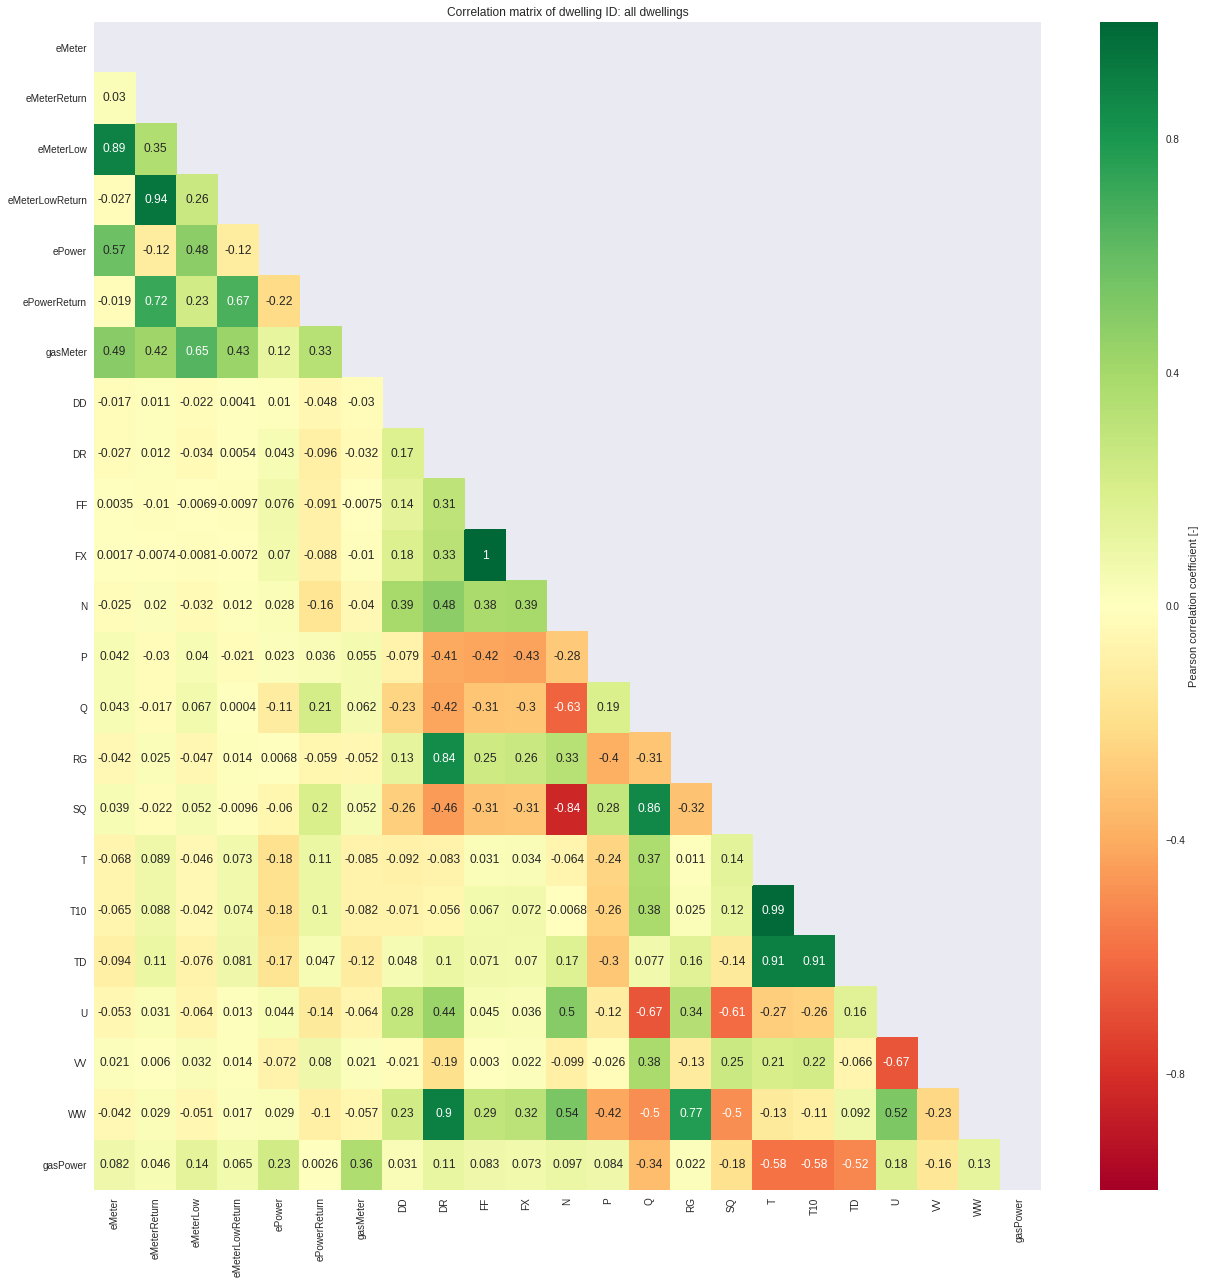

In [96]:
%%time
fig = create_corr_matrix(day, 'all dwellings', True)

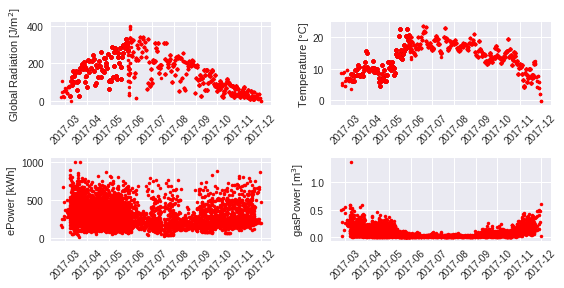

In [97]:
sns.set()

def datetime_layout():
    plt.xticks(rotation=45)
    #plt.grid()
    plt.tight_layout()

x = day.index

plt.subplot(3,2,1)
plt.plot(x, day['Q'], '.', color='r', linewidth=0.3)
#plt.xlabel('Date [-]')
plt.ylabel('Global Radiation [J/m$^2$]')
datetime_layout()

plt.subplot(3,2,2)
plt.plot(x, day['T'], '.', color='r', linewidth=0.3)
#plt.xlabel('Date [-]')
plt.ylabel('Temperature [°C]')
datetime_layout()

plt.subplot(3,2,3)
plt.plot(x, day['ePower'], '.', color='r', linewidth=0.3)
#plt.xlabel('Date [-]')
plt.ylabel('ePower [kWh]')
datetime_layout()

plt.subplot(3,2,4)
plt.plot(x, day['gasPower'], '.', color='r', linewidth=0.3)
#plt.xlabel('Date [-]')
plt.ylabel('gasPower [m$^3$]')
datetime_layout()

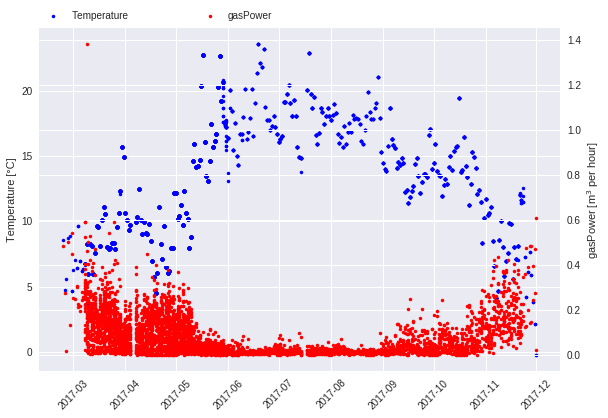

In [98]:
fig, ax = plt.subplots()
datetime_layout()

ax.plot(x, day['T'], 'b.', linewidth=0.5, label='Temperature')
ax.set_ylabel('Temperature [°C]')
ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), borderaxespad=0, frameon=False) # Put legend on custom location
# more legend info: https://jdhao.github.io/2018/01/23/matplotlib-legend-outside-of-axes/

ax = ax.twinx() 
ax.plot(x, day.gasPower, 'r.', linewidth=0.5, label='gasPower')
ax.set_ylabel('gasPower [m$^3$ per hour]')

ax.legend(loc='lower left', bbox_to_anchor= (0.3, 1.01), borderaxespad=0, frameon=False)

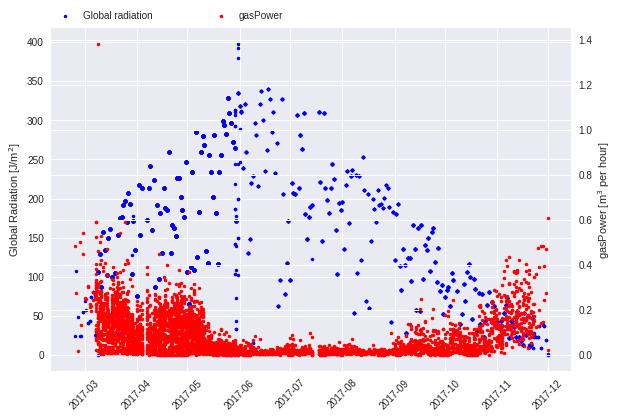

In [99]:
fig, ax = plt.subplots()
datetime_layout()

ax.plot(x, day['Q'], 'b.', linewidth=0.5, label='Global radiation')
ax.set_ylabel('Global Radiation [J/m$^2$]')
ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), borderaxespad=0, frameon=False) # Put legend on custom location
# more legend info: https://jdhao.github.io/2018/01/23/matplotlib-legend-outside-of-axes/

ax = ax.twinx() 
ax.plot(x, day.gasPower, 'r.', linewidth=0.5, label='gasPower')
ax.set_ylabel('gasPower [m$^3$ per hour]')

ax.legend(loc='lower left', bbox_to_anchor= (0.3, 1.01), borderaxespad=0, frameon=False)

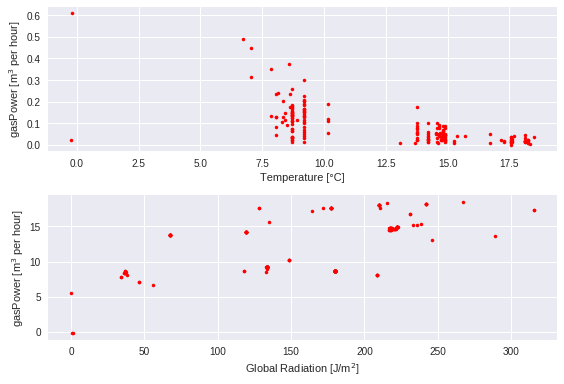

In [89]:
plt.subplot(2,1,1)
plt.plot(day['T'], day['gasPower'], '.', color='r', linewidth=0.3)
plt.ylabel('gasPower [m$^3$ per hour]')
plt.xlabel('Temperature [°C]')
plt.tight_layout()

plt.subplot(2,1,2)
plt.plot(day['Q'], day['T'], '.', color='r', linewidth=0.3)
plt.ylabel('gasPower [m$^3$ per hour]')
plt.xlabel('Global Radiation [J/m$^2$]')
plt.tight_layout()

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1.23,'1 Day mean of all dwellings')

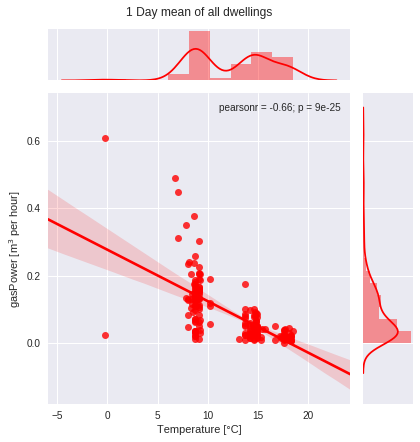

In [90]:
fig = sns.jointplot(x="T", y="gasPower", data=day, kind="reg", color='r')
sns.plt.ylabel('gasPower [m$^3$ per hour]')
sns.plt.xlabel('Temperature [°C]')
sns.plt.tight_layout()
sns.plt.title('1 Day mean of all dwellings', y=1.23)

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1.23,'1 Day mean of all dwellings')

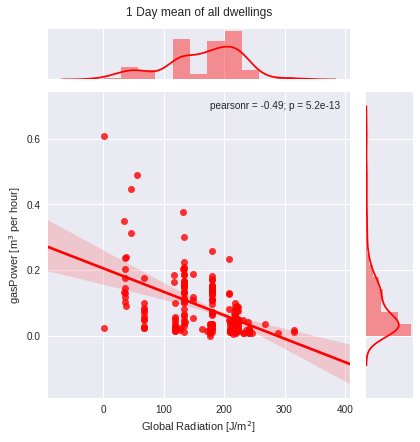

In [91]:
fig = sns.jointplot(x="Q", y="gasPower", data=day, kind="reg", color='r')
sns.plt.ylabel('gasPower [m$^3$ per hour]')
sns.plt.xlabel('Global Radiation [J/m$^2$]')
sns.plt.tight_layout()
sns.plt.title('1 Day mean of all dwellings', y=1.23)

Text(0.5,0,'gasPower')

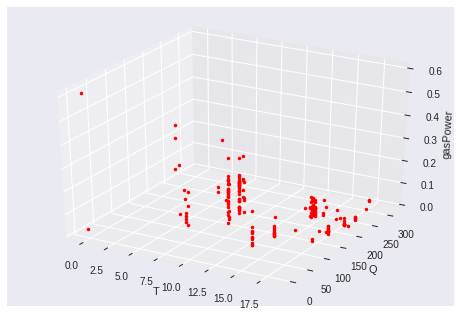

In [92]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(day['T'], day['Q'], day['gasPower'], '.', color='r')

ax.set_xlabel('T')
ax.set_ylabel('Q')
ax.set_zlabel('gasPower')

Text(0.5,0,'gasPower')

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


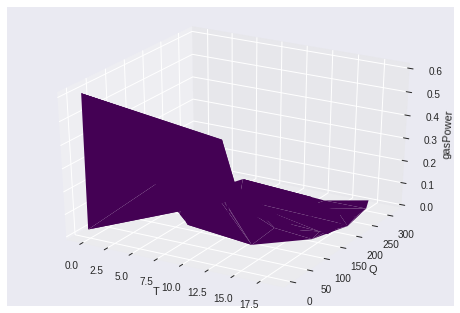

In [93]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(day['T'], day['Q'], day['gasPower'], cmap=plt.cm.viridis, linewidth=0.2, antialiased=True)

ax.set_xlabel('T')
ax.set_ylabel('Q')
ax.set_zlabel('gasPower')

# Multivariable linear regression: predict gasPower

In [94]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Nobody turns on their heating when T > 19?, so deselect this data
data = day[day['T'] < 19]



#X = filtered.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1)
X = data[['T', 'Q']]
print('X columns: %s' % list(X.columns))
y = data['gasPower']

X = np.array(X).reshape(-1,len(X.columns)) # Reshape because sklearn wants you to
y = np.array(y).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

X columns: ['T', 'Q']


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

Text(0.5,0,'gasPower')

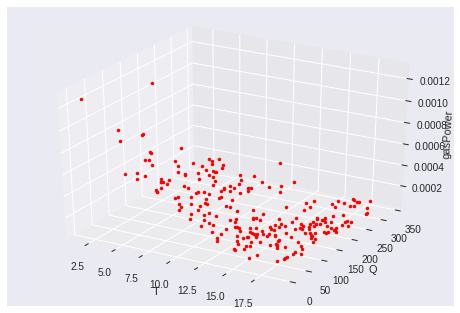

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(data['T'], data['Q'], data['gasPower'], '.', color='r')

ax.set_xlabel('T')
ax.set_ylabel('Q')
ax.set_zlabel('gasPower')

Text(0.5,0,'gasPower')

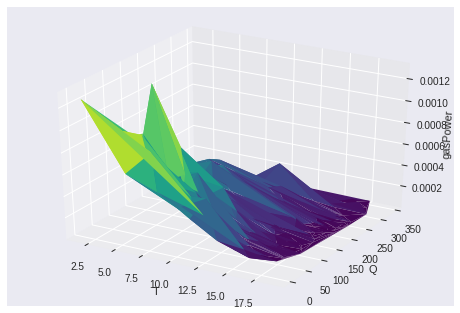

In [19]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(data['T'], data['Q'], data['gasPower'], cmap=plt.cm.viridis, linewidth=0.2, antialiased=True)

ax.set_xlabel('T')
ax.set_ylabel('Q')
ax.set_zlabel('gasPower')

# Multivariable linear regression: predict gasPower with more variables

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

data = day[day['T'] < 19]

X = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter','gasPower', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1)
print('X columns: %s' % list(X.columns))
y = data['gasPower']

X = np.array(X).reshape(-1,len(X.columns)) # Reshape because sklearn wants you to
y = np.array(y).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

X columns: ['ePower', 'ePowerReturn', 'DD', 'FF', 'N', 'Q', 'RG', 'T', 'U']


0.869056234403075

This is quite high....

In [21]:
model.coef_

array([[  1.09879591e-06,  -8.05934576e-07,   2.01520862e-08,
         -1.85140834e-07,  -6.46427270e-06,   7.82622820e-08,
         -3.26596346e-05,  -3.67122921e-05,   1.01051978e-06]], dtype=float32)

# Multivariable linear regression: predict ePower

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

data = day[day['T'] < 19]

X = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter','ePower','ePowerReturn', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1)
print('X columns: %s' % list(X.columns))
y = data['ePower']

X = np.array(X).reshape(-1,len(X.columns)) # Reshape because sklearn wants you to
y = np.array(y).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

X columns: ['gasPower', 'DD', 'FF', 'N', 'Q', 'RG', 'T', 'U']


0.6494359218086827

In [23]:
model.coef_

array([[  1.48694609e+05,  -3.82129438e-02,   3.38594389e+00,
          2.29665637e+00,  -4.51451838e-02,   7.12998033e-01,
         -4.38919973e+00,  -7.33409047e-01]], dtype=float32)

# Deep learning
## Initialize tensorflow setup

In [24]:
"""
Setup multi GPU usage

Example usage:
model = Sequential()
...
multi_model = multi_gpu_model(model, gpus=num_gpu)
multi_model.fit()

About memory usage:
https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
"""
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib

# IMPORTANT: Tells tf to not occupy a specific amount of memory
from keras.backend.tensorflow_backend import set_session  
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU  
sess = tf.Session(config=config)  
set_session(sess)  # set this TensorFlow session as the default session for Keras.


# getting the number of GPUs 
def get_available_gpus():
   local_device_protos = device_lib.list_local_devices()
   return [x.name for x in local_device_protos if x.device_type    == 'GPU']
num_gpu = len(get_available_gpus())
print('Amount of GPUs available: %s' % num_gpu)

/opt/jupyterhub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


Amount of GPUs available: 4


# Preprocessing data

In [25]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

data = day[day['T'] < 19]
epower = data.iloc[:,0].values.reshape(-1,1) # select and reshape gasPower

# scale the data
#scaler = MinMaxScaler(feature_range=(0,1), copy=True)
scaler = StandardScaler()

epower = scaler.fit_transform(epower)

In [26]:
# Split predictors from targets
X = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter','gasPower','ePowerReturn', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1)
print('X columns: %s' % list(X.columns))
y = data[['gasPower']]

X columns: ['ePower', 'DD', 'FF', 'N', 'Q', 'RG', 'T', 'U']


In [27]:
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Scale the data
#X_train = preprocessing.scale(X_train)
#X_test = preprocessing.scale(X_test)
#y_train = np.array(y_train)
#y_test = np.array(y_test)

#y_train = preprocessing.scale(y_train) # No need to scale the y's ?
#y_test = preprocessing.scale(y_test)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('')
print('X_train variance', X_train.var())
print('y_train variance', y_train.var())

X_train shape: (48, 8)
X_test shape: (193, 8)
y_train shape: (48, 1)
y_test shape: (193, 1)

X_train variance 1.00807805953
y_train variance 1.12098399425


# Create the keras model

In [29]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(Dense(8, input_shape=(8,), kernel_initializer='normal'))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(16*16))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(16*16))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(1, kernel_initializer='normal'))
#model.add(Activation('linear'))

# Compile and fit

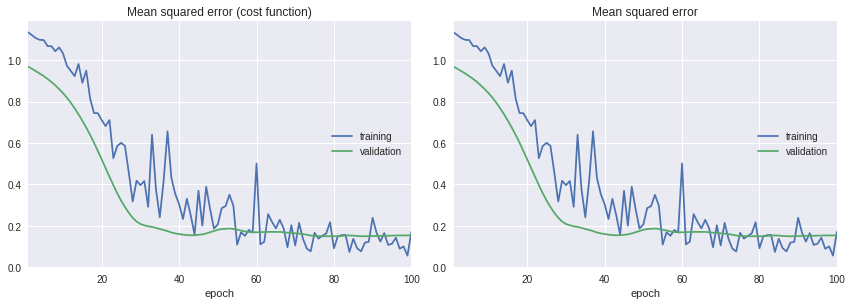

 - 0s - loss: 0.1696 - mean_squared_error: 0.1696 - val_loss: 0.1549 - val_mean_squared_error: 0.1549


In [30]:
multi_model = multi_gpu_model(model, gpus=num_gpu)

# compiling the sequential model
multi_model.compile(loss='mean_squared_error', metrics=['mse'], optimizer='adam')

early_stopping_monitor = EarlyStopping(patience=100)

from livelossplot import PlotLossesKeras

# training the model and saving metrics in history
multi_model.fit(X_train, y_train, batch_size=int(len(X_train)), epochs=100, verbose=2, validation_data=(X_test, y_test), callbacks=[early_stopping_monitor, PlotLossesKeras()])

How to interpret mean squared error:  
`The MSE is a measure of the quality of an estimator—it is always non-negative, and values closer to zero are better.`  
https://en.wikipedia.org/wiki/Mean_squared_error

# Keras on higher resolution data
## Preprocessing data

In [25]:
%%time
data = df
data = data.set_index(['datetime'])
data = data.resample('H').mean()

CPU times: user 12.4 s, sys: 11.8 s, total: 24.2 s
Wall time: 22.8 s


In [26]:
"""
Create columns with time information. 
The idea is that the neural network will start taking time into account also.
"""
data['hour'] = data.index.hour
#data['minute'] = data.index.minute
#data['second'] = data.index.second
data = data.dropna()
data.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,gasPower,DD,DR,...,Q,RG,SQ,T,T10,TD,U,VV,WW,hour
datetime,,,,,,,,,,,,,,,,,,,,,
2017-02-28 11:00:00,2328.599854,0.0,2944.616943,0.0,178.474457,0.0,2185.584961,0.000000,218.750000,0.0,...,118.666664,0.0,2.3526,5.183333,4.916667,2.800000,84.000000,39750.000000,15.500000,11
2017-02-28 12:00:00,2328.842041,0.0,2944.616943,0.0,296.830017,0.0,2186.257080,0.001867,213.524994,0.0,...,112.500000,0.0,0.0000,5.183333,5.183333,2.533333,82.666664,45983.332031,2.166667,12
2017-02-28 13:00:00,2329.015625,0.0,2944.616943,0.0,169.900284,0.0,2186.555908,0.000830,212.316666,0.0,...,144.399994,0.0,0.0000,5.300000,5.260000,2.540000,82.000000,42540.000000,2.000000,13
2017-02-28 14:00:00,2329.183838,0.0,2944.616943,0.0,138.646133,0.0,2186.830078,0.000762,224.399994,0.0,...,151.666672,0.0,0.0000,5.283333,5.500000,2.166667,79.666664,41350.000000,1.166667,14
2017-02-28 15:00:00,2329.478271,0.0,2944.616943,0.0,442.744354,0.0,2187.288086,0.001272,226.983337,0.0,...,246.666672,0.0,3.0582,5.516667,6.000000,2.500000,80.833336,45683.332031,1.666667,15


In [27]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

epower = data.iloc[:,0].values.reshape(-1,1) # select and reshape gasPower

# scale the data
#scaler = MinMaxScaler(feature_range=(0,1), copy=True)
scaler = StandardScaler()

epower = scaler.fit_transform(epower)

# Split predictors from targets
X = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter','gasPower','ePowerReturn', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1)
print('X columns: %s' % list(X.columns))
y = data[['gasPower']]

X columns: ['ePower', 'DD', 'FF', 'N', 'Q', 'RG', 'T', 'U', 'hour']


In [28]:
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the data
#X_train = preprocessing.scale(X_train)
#X_test = preprocessing.scale(X_test)
#y_train = np.array(y_train)
#y_test = np.array(y_test)

#y_train = preprocessing.scale(y_train) # No need to scale the y's ?
#y_test = preprocessing.scale(y_test)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('')
print('X_train variance', X_train.var())
print('y_train variance', y_train.var())

X_train shape: (4494, 9)
X_test shape: (1927, 9)
y_train shape: (4494, 1)
y_test shape: (1927, 1)

X_train variance 0.984623231747
y_train variance 1.42782358128


# Creating the model

In [80]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(Dense(9, input_shape=(9,), kernel_initializer='normal'))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(16*16, kernel_initializer='normal'))
model.add(Activation('relu'))
model.add(Dropout(0.2))


model.add(Dense(1, kernel_initializer='normal'))
#model.add(Activation('linear'))

# Compile and fit

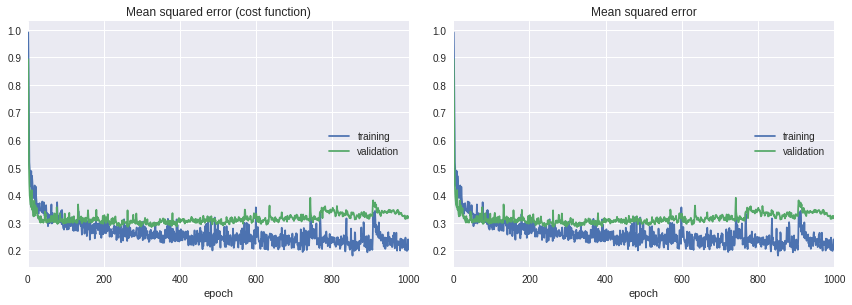

 - 0s - loss: 0.2021 - mean_squared_error: 0.2021 - val_loss: 0.3198 - val_mean_squared_error: 0.3198
CPU times: user 8min 47s, sys: 1min 1s, total: 9min 48s
Wall time: 6min 21s


In [81]:
%%time
multi_model = multi_gpu_model(model, gpus=num_gpu)

# compiling the sequential model
multi_model.compile(loss='mean_squared_error', metrics=['mse'], optimizer='Nadam')

early_stopping_monitor = EarlyStopping(patience=5000)

from livelossplot import PlotLossesKeras

# training the model and saving metrics in history
multi_model.fit(X_train, y_train, batch_size=int(len(X_train)/10), epochs=1000, verbose=2, validation_data=(X_test, y_test), callbacks=[early_stopping_monitor, PlotLossesKeras()])

Higher resolution will give worse results (But why? The hour column is there...)

# Do the same, but to predict energy usage
## Preprocessing

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

epower = data.iloc[:,0].values.reshape(-1,1) # select and reshape gasPower

# scale the data
#scaler = MinMaxScaler(feature_range=(0,1), copy=True)
scaler = StandardScaler()

epower = scaler.fit_transform(epower)

# Split predictors from targets
X = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter', 'ePower','ePowerReturn', 'WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1)
print('X columns: %s' % list(X.columns))
y = data[['ePower']]

In [166]:
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Scale the data
#X_train = preprocessing.scale(X_train)
#X_test = preprocessing.scale(X_test)
#y_train = np.array(y_train)
#y_test = np.array(y_test)

#y_train = preprocessing.scale(y_train) # No need to scale the y's ?
#y_test = preprocessing.scale(y_test)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('')
print('X_train variance', X_train.var())
print('y_train variance', y_train.var())

X_train shape: (322, 9)
X_test shape: (1289, 9)
y_train shape: (322, 1)
y_test shape: (1289, 1)

X_train variance 0.955527843526
y_train variance 1.02264132679


# Create the model

In [171]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(Dense(9, input_shape=(9,), kernel_initializer='normal'))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(16*16))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(1, kernel_initializer='normal'))
#model.add(Activation('linear'))

# Compile and fit

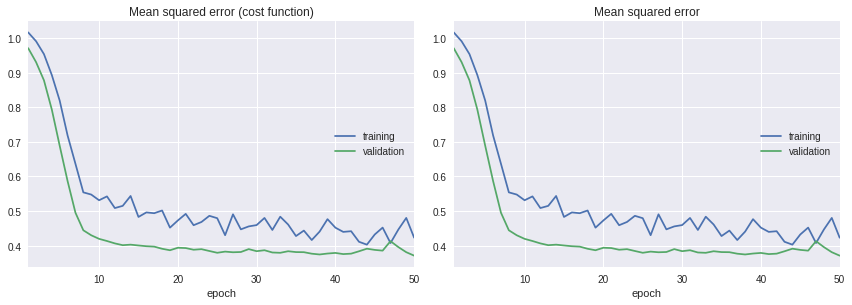

 - 0s - loss: 0.4229 - mean_squared_error: 0.4229 - val_loss: 0.3709 - val_mean_squared_error: 0.3709
CPU times: user 38.5 s, sys: 4.97 s, total: 43.4 s
Wall time: 23.7 s


In [172]:
%%time
multi_model = multi_gpu_model(model, gpus=num_gpu)

# compiling the sequential model
multi_model.compile(loss='mean_squared_error', metrics=['mse'], optimizer='adam')

early_stopping_monitor = EarlyStopping(patience=100)

from livelossplot import PlotLossesKeras

# training the model and saving metrics in history
multi_model.fit(X_train, y_train, batch_size=int(len(X_train)/10), epochs=50, verbose=2, validation_data=(X_test, y_test), callbacks=[early_stopping_monitor, PlotLossesKeras()])